In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

from trasim_simplified.core.kinematics.cfm import get_cf_func
from trasim_simplified.core.constant import CFM

dt = 0.1
cf_name = CFM.IDM
cf_func = get_cf_func(cf_name)
param_names = ["s0", "v0", "T", "omega", "d", "delta"]
# param_names = ["k1", "k2", "thw", "s0"]

# 轨迹加载

In [2]:
from trasim_simplified.util.tools import load_from_pickle, save_to_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix
import numpy as np

clb_type = "acc"

# 读取轨迹
traj_s_full_ori: dict[str, dict] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\ori_full_traj_s.pkl")
# 去除NaN轨迹对
invalid_pairs = np.load(r"E:\PyProject\car-following-model-test\tests\data\invalid_ids.npy")
traj_s_full_ori["dec"] = {k: v for k, v in traj_s_full_ori["dec"].items() if k not in invalid_pairs}
traj_s_full_ori["acc"] = {k: v for k, v in traj_s_full_ori["acc"].items() if k not in invalid_pairs}

save_to_pickle(traj_s_full_ori, r"E:\PyProject\car-following-model-test\tests\data\ori_full_traj_s.pkl")

traj_s_cut_pos = {pair_id: len(df_pair) for pair_id, df_pair in traj_s_full_ori["dec"].items()}

if clb_type == "full":
    traj_s_full: dict[str, pd.DataFrame] = {pair_id: pd.concat([df_pair, traj_s_full_ori["acc"][pair_id]]) for pair_id, df_pair in traj_s_full_ori["dec"].items()}
elif clb_type == "dec" or clb_type == "acc":
    traj_s_full: dict[str, pd.DataFrame] = traj_s_full_ori[clb_type]
else:
    raise ValueError(f"clb_type: {clb_type} is not supported!")

obs_x_s = [traj_s_full[k][TI.x] for k in traj_s_full.keys()]
obs_v_s = [traj_s_full[k][TI.v] for k in traj_s_full.keys()]
obs_lx_s = [traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()]
obs_lv_s = [traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()]
leaderL_s = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()]
id_s = [k for k in traj_s_full.keys()]
print(len(id_s))

690


# 参数标定

In [3]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_run

# 跟驰模型参数标定
results = clb_run(
    cf_func=cf_func, cf_name=cf_name,
    obs_x_s=obs_x_s, obs_v_s=obs_v_s, obs_lx_s=obs_lx_s, obs_lv_s=obs_lv_s, leaderL_s=leaderL_s,
    dt=0.1, seed=2024, drawing=0, n_jobs=-1,
    cf_param_ranges_=None
)

Using geatpy


100%|██████████| 690/690 [03:18<00:00,  3.48it/s]


In [4]:
from trasim_simplified.util.calibrate.clb_cf_model import aggregate_result

avg_obj, avg_param, std_obj, std_param = aggregate_result(results)
print(f"avg_obj: {avg_obj}\navg_param: {avg_param}\nstd_obj: {std_obj}\nstd_param: {std_param}")

avg_obj: 0.41240036480743875
avg_param: [ 4.22258945 26.02904112  1.23178544  3.65087045  6.08639528  6.69710145]
std_obj: 0.3364230544690636
std_param: [ 2.64057157 12.04251495  0.7578746   2.67916628  4.21720652  3.43968616]


In [5]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_param_to_df

param_df = clb_param_to_df(id_s, results, cf_name)

param_df.to_pickle(fr"E:\PyProject\car-following-model-test\tests\data\clb_{clb_type}_param_df" + f"_{cf_name}.pkl")
param_df = pd.read_pickle(fr"E:\PyProject\car-following-model-test\tests\data\clb_{clb_type}_param_df" + f"_{cf_name}.pkl")
param_df

,s0,v0,T,omega,d,delta,Pair_ID,ObjV
0,0.100085,39.989986,1.620128,0.824899,2.923387,10.0,10,0.241589
1,2.173081,39.999943,0.971562,3.606999,9.995166,10.0,12,0.394623
2,0.649422,21.588860,1.627058,1.110076,2.635142,5.0,14,0.121275
3,5.644108,19.707308,0.904207,3.516588,9.999981,10.0,15,0.335343
4,7.133655,14.379768,0.100000,9.963386,10.000000,4.0,17,0.468448
...,...,...,...,...,...,...,...,...
685,5.769905,39.999971,0.100000,1.740354,10.000000,10.0,6569,0.375575
686,5.515243,39.999971,1.924470,1.603133,10.000000,10.0,6597,0.541363
687,4.312600,23.710709,2.611850,1.338539,0.100000,8.0,6599,0.294537
688,5.777269,36.191149,1.057271,2.648388,7.969887,10.0,6603,0.189425


## 标定参数统计性结果

In [7]:
pd.options.display.precision = 2

param_df[param_names + ["ObjV"]].describe().loc[["mean", "std", "min", "max"]]

,s0,v0,T,omega,d,delta,ObjV
mean,4.22,26.03,1.23,3.65,6.09,6.70,0.41
std,2.64,12.05,0.76,2.68,4.22,3.44,0.34
min,0.10,10.00,0.10,0.51,0.10,1.00,0.04
max,10.00,40.00,5.34,10.00,10.00,10.00,3.96


## 仿真轨迹数据生成保存

In [10]:
from trasim_simplified.util.tools import save_to_pickle
from trasim_simplified.util.calibrate.clb_cf_model import get_clb_traj

traj_s_full_: dict[str, pd.DataFrame] = {pair_id: pd.concat([df_pair, traj_s_full_ori["acc"][pair_id]]) for pair_id, df_pair in traj_s_full_ori["dec"].items()}

clb_traj_s = get_clb_traj(traj_s_full_, traj_s_cut_pos, param_df, cf_func, cf_name, dt)

save_to_pickle(clb_traj_s, fr"E:\PyProject\car-following-model-test\tests\data\clb_{clb_type}_traj_s" + f"_{cf_name}.pkl")

## 轨迹展示

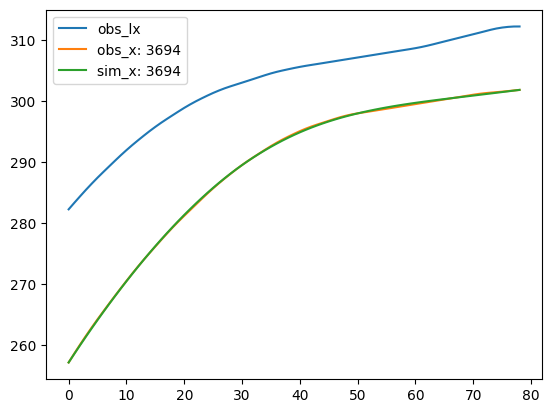

In [8]:
from trasim_simplified.util.calibrate.clb_cf_model import show_traj
import random
import numpy as np

pos = random.choice(range(len(id_s)))
id_ = id_s[pos]
# id_ = 5283
pos = np.where(np.array(id_s) == id_)[0][0]

# pos = param_df[param_df[TI.Pair_ID] == 2778].index[0]

target = param_df[param_df[TI.Pair_ID] == id_]
obs_x = obs_x_s[pos]
obs_v = obs_v_s[pos]
obs_lx = obs_lx_s[pos]
obs_lv = obs_lv_s[pos]
leaderL = leaderL_s[pos]
show_traj(cf_name, target.to_numpy().reshape(-1), dt, obs_x, obs_v, obs_lx, obs_lv, leaderL, traj_step=None, pair_ID=id_)

# 迟滞强度计算

In [ ]:
from trasim_simplified.core.constant import CFM

cf_name = CFM.IDM
if cf_name == CFM.IDM:
    param_names = ["s0", "v0", "T", "omega", "d", "delta"]
elif cf_name == CFM.ACC:
    param_names = ["k1", "k2", "thw", "s0"]
else:
    raise ValueError(f"cf_name {cf_name} error")
clb_type = "full"

df_ori: dict[str, pd.DataFrame] = pd.read_pickle(
    r'E:\PyProject\car-following-model-test\tests\data\ori_full_traj_s.pkl')
if clb_type == "full":
    df_clb: dict[str, pd.DataFrame] = pd.read_pickle(
        r"E:\PyProject\car-following-model-test\tests\data\clb_full_traj_s" + f"_{cf_name}.pkl")
    df_param: pd.DataFrame = pd.read_pickle(
        r"E:\PyProject\car-following-model-test\tests\data\clb_full_param_df" + f"_{cf_name}.pkl")
else:
    raise ValueError(f"clb_type {clb_type} error")

In [ ]:
from trasim_simplified.util.hysteresis.intensity import cal_sv_intensity, cal_acc_intensity
from trasim_simplified.core.constant import TrackInfo as TI, Prefix
from trasim_simplified.core.kinematics.cfm import get_cf_default_param, get_cf_equilibrium

ids = list(df_ori["dec"].keys())
sv_intensity = {}
ori_sv_intensity = {}
acc_intensity = {}
ori_acc_intensity = {}

cf_e = get_cf_equilibrium(cf_name)

invalid_ids = []

for id_ in ids:
    cf_param = {name: df_param[df_param[TI.Pair_ID] == id_][name].iloc[0] for name in param_names}
    l_length = df_clb["dec"][id_][Prefix.leader + TI.v_Length].iloc[0]
    df_dec = df_clb["dec"][id_]
    df_acc = df_clb["acc"][id_]
    df_dec_ori = df_ori["dec"][id_]
    df_acc_ori = df_ori["acc"][id_]

    sv_intensity[id_] = cal_sv_intensity(
        df_dec[Prefix.leader + TI.x] - df_dec[TI.x] - l_length, df_dec[TI.v],
        df_acc[Prefix.leader + TI.x] - df_acc[TI.x] - l_length, df_acc[TI.v], cf_e, cf_param)
    ori_sv_intensity[id_] = cal_sv_intensity(
        df_dec_ori[Prefix.leader + TI.x] - df_dec_ori[TI.x] - l_length, df_dec_ori[TI.v],
        df_acc_ori[Prefix.leader + TI.x] - df_acc_ori[TI.x] - l_length, df_acc_ori[TI.v], cf_e, cf_param)

    if np.isnan(sv_intensity[id_]["dec_vs"]) or np.isnan(sv_intensity[id_]["acc_vs"]) or np.isnan(
            ori_sv_intensity[id_]["dec_vs"]) or np.isnan(ori_sv_intensity[id_]["acc_vs"]):
        invalid_ids.append(id_)
a = np.array(invalid_ids)
np.save(r"E:\PyProject\car-following-model-test\tests\data\invalid_ids.npy", a)
sv_intensity

In [ ]:
column_names = sv_intensity[list(sv_intensity.keys())[0]].keys()
df_intensity = pd.DataFrame([list(v.values()) for v in sv_intensity.values()], columns=column_names)
df_intensity[TI.Pair_ID] = sv_intensity.keys()

df_ori_intensity = pd.DataFrame([v.values() for v in ori_sv_intensity.values()],
                                columns=["ori_" + name for name in column_names])
df_ori_intensity[TI.Pair_ID] = ori_sv_intensity.keys()

df_param_merge: pd.DataFrame = df_param.merge(df_intensity, on=TI.Pair_ID)
df_param_merge: pd.DataFrame = df_param_merge.merge(df_ori_intensity, on=TI.Pair_ID)
df_param_merge.to_pickle(
    r"E:\PyProject\car-following-model-test\tests\data\df_param_hysteresis_merge" + f"_{cf_name}.pkl")
df_param_merge

# 模块加速度贡献

In [ ]:
def IDM_v_module(omega, v0, delta, speed, **kwargs):
    return np.power(speed / v0, delta) * omega

def IDM_s_module(omega, s0, T, speed, gap, **kwargs):
    return np.sqrt(omega) * (s0 + speed * T) / gap

def IDM_z_module(omega, d, speed, leaderV, gap, **kwargs):
    return speed * (speed - leaderV) / (2 * np.sqrt(d)) / gap

In [ ]:
# def IDM_v_module(omega, v0, delta, speed, **kwargs):
#     return np.power(speed / v0, delta)
# 
# def IDM_s_module(omega, s0, T, speed, gap, **kwargs):
#     return (s0 + speed * T) / gap
# 
# def IDM_z_module(omega, d, speed, leaderV, gap, **kwargs):
#     return speed * (speed - leaderV) / (2 * np.sqrt(omega * d)) / gap

In [ ]:
from trasim_simplified.util.tools import load_from_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix

# 读取轨迹数据
traj_s_full_clb: dict[str, dict[str, pd.DataFrame]] = load_from_pickle(
    r"E:\PyProject\car-following-model-test\tests\data\clb_full_traj_s_IDM.pkl")
traj_s_cut_pos = {v_id: len(df_pair) for v_id, df_pair in traj_s_full_clb["dec"].items()}

traj_s_full: dict[str, pd.DataFrame] = {v_id: pd.concat([df_pair, traj_s_full_clb["acc"][v_id]]) for v_id, df_pair in
                                        traj_s_full_clb["dec"].items()}
id_s = [k for k in traj_s_full.keys()]
assert len(id_s) == len(set(id_s))
print(len(id_s))

## 计算各模块的平均加速度以及加速度贡献占比

In [ ]:
def cal_module_acc(cf_param_copy, s, v, lv):
    kv = IDM_v_module(**cf_param_copy, speed=v)
    ks = IDM_s_module(**cf_param_copy, speed=v, gap=s)
    ks_2 = np.power(ks, 2)
    kz = IDM_z_module(**cf_param_copy, speed=v, leaderV=lv, gap=s)
    kz_2 = np.power(kz, 2)
    ksz = 2 * ks * kz
    return kv, ks_2, kz_2, ksz

In [ ]:
def cal_acc_contribution(cf_param: dict, dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, dec_lv, acc_lv):
    cf_param_copy = cf_param.copy()

    # 计算平均加速度
    dec_kv, dec_ks_2, dec_kz_2, dec_ksz = np.mean(cal_module_acc(cf_param_copy, dec_s, dec_v, dec_lv), axis=1)
    acc_kv, acc_ks_2, acc_kz_2, acc_ksz = np.mean(cal_module_acc(cf_param_copy, acc_s, acc_v, acc_lv), axis=1)

    # 计算加速度贡献占比
    omega = cf_param_copy["omega"]
    # omega = 1
    dec_total_a = omega + dec_kv + dec_ks_2 + dec_kz_2 + np.abs(dec_ksz)
    dec_kv_percent = dec_kv / dec_total_a
    dec_ks_2_percent = dec_ks_2 / dec_total_a
    dec_kz_2_percent = dec_kz_2 / dec_total_a
    dec_ksz_percent = np.abs(dec_ksz) / dec_total_a
    dec_omega_percent = omega / dec_total_a

    acc_total_a = omega + acc_kv + acc_ks_2 + acc_kz_2 + np.abs(acc_ksz)
    acc_kv_percent = acc_kv / acc_total_a
    acc_ks_2_percent = acc_ks_2 / acc_total_a
    acc_kz_2_percent = acc_kz_2 / acc_total_a
    acc_ksz_percent = np.abs(acc_ksz) / acc_total_a
    acc_omega_percent = omega / acc_total_a

    # 计算全过程的加速度贡献占比
    kv = np.mean([dec_kv, acc_kv])  # 前车减速过程的平均加速度
    ks_2 = np.mean([dec_ks_2, acc_ks_2])  # 前车减速过程的平均加速度
    kz_2 = np.mean([dec_kz_2, acc_kz_2])  # 前车减速过程的平均加速度
    ksz = np.mean([np.abs(dec_ksz), np.abs(acc_ksz)])
    total_a = kv + ks_2 + kz_2 + ksz
    kv_percent = kv / total_a
    ks_2_percent = ks_2 / total_a
    kz_2_percent = kz_2 / total_a
    ksz_percent = ksz / total_a
    omega_percent = omega / total_a

    # 前后车两者在减速过程中的平均加速度差值，即两者速度变化量的差异
    return {
        "dec_la_mean": np.mean(dec_a), "acc_la_mean": np.mean(acc_a),
        "dec_kv": dec_kv, "dec_ks_2": dec_ks_2, "dec_kz_2": dec_kz_2, "dec_ksz": dec_ksz, "dec_omega": omega,
        "acc_kv": acc_kv, "acc_ks_2": acc_ks_2, "acc_kz_2": acc_kz_2, "acc_ksz": acc_ksz, "acc_omega": omega,
        "dec_kv_percent": dec_kv_percent, "dec_ks_2_percent": dec_ks_2_percent, "dec_kz_2_percent": dec_kz_2_percent,
        "dec_ksz_percent": dec_ksz_percent, "dec_omega_percent": dec_omega_percent,
        "acc_kv_percent": acc_kv_percent, "acc_ks_2_percent": acc_ks_2_percent, "acc_kz_2_percent": acc_kz_2_percent,
        "acc_ksz_percent": acc_ksz_percent, "acc_omega_percent": acc_omega_percent,
        "kv": kv, "ks_2": ks_2, "kz_2": kz_2, "ksz": ksz, "omega": omega,
        "kv_percent": kv_percent, "ks_2_percent": ks_2_percent, "kz_2_percent": kz_2_percent,
        "ksz_percent": ksz_percent, "omega_percent": omega_percent,
    }

In [ ]:
param_names = ["s0", "v0", "T", "omega", "d", "delta"]

In [ ]:
import tqdm

for pair_id in tqdm.tqdm(id_s):
    cf_param = {name: df_param_merge[df_param_merge[TI.Pair_ID] == pair_id][name].iloc[0] for name in param_names}
    temp_dec = traj_s_full_clb["dec"][pair_id]
    temp_acc = traj_s_full_clb["acc"][pair_id]
    # dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, dec_lv, acc_lv
    acc_contribution_result = cal_acc_contribution(
        cf_param,
        temp_dec[TI.gap],
        temp_dec[TI.v],
        temp_acc[TI.gap],
        temp_acc[TI.v],
        temp_dec[TI.a],
        temp_acc[TI.a],
        temp_dec[Prefix.leader + TI.v],
        temp_acc[Prefix.leader + TI.v]
    )
    df_param_merge.loc[df_param_merge[TI.Pair_ID] == pair_id, list(acc_contribution_result.keys())] = list(
        acc_contribution_result.values())

df_param_merge.to_pickle(
    r"E:\PyProject\car-following-model-test\tests\data\df_param_hysteresis_merge_module" + f"_{cf_name}.pkl")
df_param_merge